In [30]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Mounted at /content/gdrive


In [31]:
#Path to the main directory
folder_path = '/content/gdrive/My Drive/Colab Notebooks/InnSure/pdl_query/'
breach_control2 = folder_path + 'mergedProfiles_BreachCtrl2.csv'

In [32]:
import pandas as pd
import numpy as np
import time
from datetime import datetime
import pickle
import os
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, plot_precision_recall_curve
from sklearn.metrics import make_scorer, precision_recall_curve, classification_report

# **Load dataset - Breach and Control2**

In [33]:
df = pd.read_csv(breach_control2)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671 entries, 0 to 670
Columns: 308 entries, Unnamed: 0 to breach
dtypes: float64(6), int64(290), object(12)
memory usage: 1.6+ MB


In [6]:
# Delete columns with all rows = 0
df = df.loc[:, (df != 0).any(axis=0)]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671 entries, 0 to 670
Columns: 229 entries, Unnamed: 0 to breach
dtypes: float64(6), int64(211), object(12)
memory usage: 1.2+ MB


# **Preprocessing and get dataframe for modeling**

In [34]:
# Drop columns with lots of missing values
df = df.drop(['birth_year','est_age_at_breach','Unnamed: 0','Unnamed: 0.1'], 1)

# Combine to one variable: numer of social media account available
df['num_social_media'] = df['linkedin_url']+ df['facebook_url'] + df['twitter_url']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671 entries, 0 to 670
Columns: 305 entries, id to num_social_media
dtypes: float64(4), int64(289), object(12)
memory usage: 1.6+ MB


In [ ]:
df.to_csv('mergedProfiles_BreachCtrl2_tomodel_allCols.csv')

In [36]:
# Get list of skills (for visualization later) 
skill_list = [col for col in df.columns if col.endswith('_skill')]

In [37]:
df.other.value_counts()
df["other"] = np.where(df["other"] >0, 1, 0)

In [ ]:
df.columns.values.tolist()

In [38]:
# List of human-related features
human_features = ['breach','gender','connections','num_social_media','num languages','proxy_yrs_since_edu', 'yrs_in_til_breach',
                  'true_yrs_of_exp','highest_level', 'associates','bachelors','masters','doctorates',
                  'mba','jd','md','technical','business','other','educational','cissp','ccna','cbcp','cciso','ccsp','cism','cisa','crisc',
                  'nonprofit','private','public']

human_features = human_features + skill_list

# Subset the dataframe to get only human-related features. This will be our main dataset for modeling
data = df[human_features]

In [ ]:
data.to_csv('mergedProfiles_BreachCtrl2_tomodel.csv')

In [39]:
# List of categorical features
cat = ['breach','gender','highest_level', 'associates','bachelors','masters','doctorates','mba','jd','md','cissp','ccna',
       'cbcp','cciso','ccsp','cism','cisa','crisc','technical','business','other']
cat = cat + skill_list

# Fill NA with 'missing', values in cat to category type:
for i in cat:
  data[i] = data[i].fillna('missing')
  data[i] = data[i].astype('category')


# Impute missing values of 'proxy_yrs_since_edu' and 'connections' with median value
data['proxy_yrs_since_edu'] = data['proxy_yrs_since_edu'].fillna(data['proxy_yrs_since_edu'].median())
data['connections'] = data['connections'].fillna(data['connections'].median())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

In [40]:
categorical_mask = (data.dtypes == 'category')
categorical_columns = data.columns[categorical_mask].tolist()
print(data[categorical_columns].head())

  breach   gender highest_level associates bachelors masters doctorates mba  \
0      1     male    doctorates          0         1       0          1   0   
1      1     male       masters          0         1       1          0   1   
2      1  missing    doctorates          0         1       0          1   0   
3      1     male       missing          0         0       0          0   0   
4      1     male     bachelors          0         1       0          0   0   

  jd md  ... technical support_skill cisco technologies_skill windows_skill  \
0  0  1  ...                       0                        0             0   
1  0  0  ...                       0                        0             0   
2  0  1  ...                       0                        0             0   
3  0  0  ...                       0                        0             0   
4  0  0  ...                       0                        0             0   

  outsourcing_skill clinical research_skill  \
0  

# **Visualization**

In [ ]:
data.head(2)

,breach,gender,connections,num_social_media,num languages,proxy_yrs_since_edu,yrs_in_til_breach,true_yrs_of_exp,highest_level,associates,...,project portfolio management_skill,research_skill,policy_skill,government_skill,technical support_skill,outsourcing_skill,clinical research_skill,penetration testing_skill,healthcare consulting_skill,pmp_skill
0,1,male,780.0,1,3,17.0,2,17,doctorates,0,...,0,0,0,0,0,0,1,0,0,0
1,1,male,3652.0,1,2,5.0,3,23,masters,0,...,1,0,0,0,0,0,0,0,0,1


### **Proportion of executive with InfoSec certifications**

In [41]:
certs = data[['breach','cissp','ccna','cbcp','cciso','ccsp','cism','cisa','crisc']]

certs_melt = pd.melt(certs, 
                          id_vars=['breach'], 
                          value_vars = ['cissp','ccna','cbcp','cciso','ccsp','cism','cisa','crisc'])\
                  .rename({'variable':'cert'},axis=1)\
                  .dropna(subset=['value'],axis=0)

certs_melt = certs_melt.groupby(['breach','cert','value']).size().reset_index(name='counts')
certs_melt['prop'] = 100 * certs_melt['counts'] / certs_melt.groupby(['breach','cert'])['counts'].transform('sum')
certs_melt_1 = certs_melt[certs_melt['value']==1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


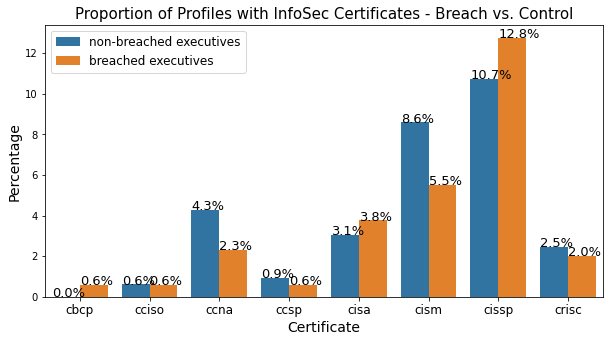

<Figure size 1600x800 with 0 Axes>

In [42]:
# plot barplot


certs_melt_1['breach'] = np.where(certs_melt_1['breach'] == 0, "non-breached executives", "breached executives")
from matplotlib import rc
fig_dims = (10, 5)
fig, ax = plt.subplots(figsize=fig_dims)
ax = sns.barplot(x="cert",
           y="prop",
           hue="breach",
           data=certs_melt_1)

for p in ax.patches:
    txt = str(p.get_height().round(1)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    ax.text(txt_x,txt_y,txt, fontsize=13)
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage', fontsize=14)
ax.set_xlabel('Certificate',fontsize=14)
ax.set_title('Proportion of Profiles with InfoSec Certificates - Breach vs. Control', fontsize=15)
ax.legend(title = '',fontsize=12)
ax.xaxis.set_tick_params(labelsize=12)


plt.rcParams['axes.grid'] = False
plt.rcParams['savefig.transparent'] = True
fig.savefig('full_figure.png')
fig= plt.figure(figsize=(20, 10), dpi=80)

fig.tight_layout()
plt.show()

In [43]:
data['breach'] = np.where(data['breach'] == 0, "non-breached executives", "breached executives")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


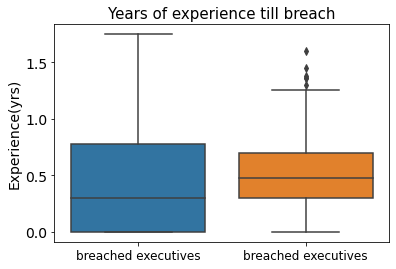

<Figure size 1600x800 with 0 Axes>

In [44]:
fig_dims = (6, 4)
fig, ax = plt.subplots(figsize=fig_dims)
ax = sns.boxplot(x="breach",y=np.log10(data['yrs_in_til_breach']),data=data)
ax.set_ylabel('Experience(yrs)', fontsize=14)
ax.set_xlabel('',fontsize=14)
ax.set_title('Years of experience till breach', fontsize=15)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xticklabels(data['breach'],fontsize=12)


plt.rcParams['axes.grid'] = False
plt.rcParams['savefig.transparent'] = True
fig.savefig('full_figure.png')
fig= plt.figure(figsize=(20, 10), dpi=80)

fig.tight_layout()
plt.show()

### **Proportion of executive with popular skills**

In [46]:
#number of profiles with this skill
skills = df[skill_list]
skills = skills.fillna(0)
count_skills = skills.astype(bool).sum(axis=0)
count_skills.sort_values(ascending= False)
count_skills = count_skills.reset_index().rename(columns={'index': 'skill', 0:'count_nonzero'})

top30 = count_skills.sort_values('count_nonzero',ascending= False).head(30)
top30_skills = top30.skill.unique().tolist()


In [47]:
# Divide top 30 skills into leadership/business skills and technical skills - for visualization purpose
top_softskills = ['management_skill',
 'project management_skill',
 'program management_skill',
 'vendor management_skill',
 'process improvement_skill',
 'business process improvement_skill',
 'networking_skill',
 'team leadership_skill',
 'risk management_skill',
 'team building_skill',
 'cross functional team leadership_skill',
 'governance_skill',
 'business continuity_skill',
 'consulting_skill']
top_techskills = ['disaster recovery_skill',
 'cloud computing_skill',
 'enterprise architecture_skill',
 'business intelligence_skill',
 'enterprise software_skill',
 'data center_skill',
 'network security_skill',
 'healthcare information technology_skill',
 'hipaa_skill',
 'virtualization_skill',
 'ehr_skill',
 'active directory_skill',
 'computer security_skill',
 'cissp_skill']

In [48]:
top_softskills.append('breach')

In [49]:
topskills = df[top_softskills]
topskills_melt = pd.melt(topskills, id_vars=['breach'], value_vars = top_softskills).rename({'variable':'skill'},axis=1).dropna(subset=['value'],axis=0)

topskills_melt = topskills_melt.groupby(['breach','skill','value']).size().reset_index(name='counts')
topskills_melt['prop'] = 100 * topskills_melt['counts'] / topskills_melt.groupby(['breach','skill'])['counts'].transform('sum')
topskills_melt_1 = topskills_melt[topskills_melt['value']==1]
topskills_melt_1['skill']= [x[:-6] for x in topskills_melt_1['skill'] if x.endswith('skill')]
topskills_melt_1.skill = topskills_melt_1.skill.str.replace('management','mgmt')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


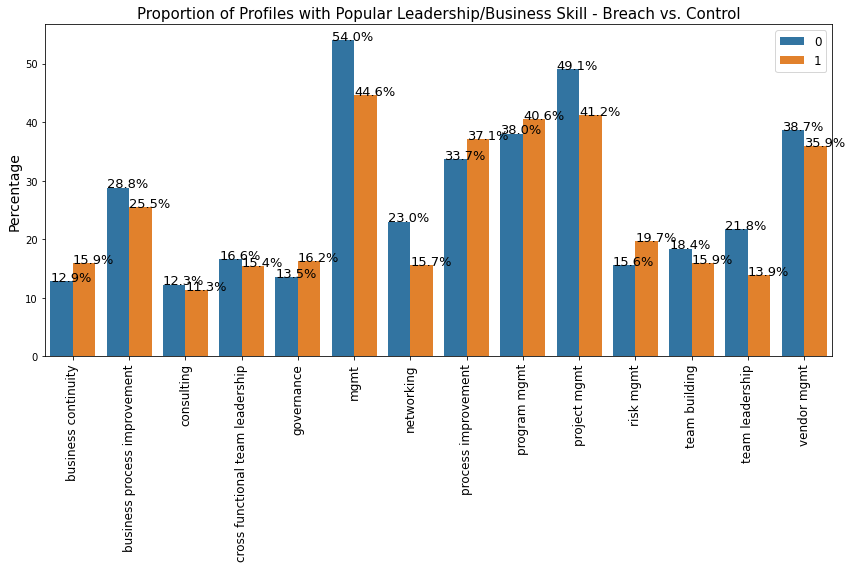

In [50]:
# plot barplot

#topskills_melt_1['breach'] = np.where(topskills_melt_1['breach'] == 0, "non-breached executives", "breached executives")
fig_dims = (12, 8)
fig, ax = plt.subplots(figsize=fig_dims)
ax = sns.barplot(x="skill",
           y="prop",
           hue="breach",
           data=topskills_melt_1)

for p in ax.patches:
    txt = str(p.get_height().round(1)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    ax.text(txt_x,txt_y,txt, fontsize=13)
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage', fontsize=14)
ax.set_xlabel('')
ax.set_title('Proportion of Profiles with Popular Leadership/Business Skill - Breach vs. Control', fontsize=15)
ax.legend(title = '', fontsize=12)
ax.set_xticklabels(topskills_melt_1['skill'], rotation=90, fontsize=12)

plt.rcParams['axes.grid'] = False
plt.rcParams['savefig.transparent'] = True
#fig.savefig('full_figure.png')
fig.savefig('myfile.png', bbox_inches = "tight")
fig.tight_layout()

plt.show()




In [51]:
top_techskills.append('breach')
topskills2 = df[top_techskills]
topskills2_melt = pd.melt(topskills2, id_vars=['breach'], value_vars = top_techskills).rename({'variable':'skill'},axis=1).dropna(subset=['value'],axis=0)

topskills2_melt = topskills2_melt.groupby(['breach','skill','value']).size().reset_index(name='counts')
topskills2_melt['prop'] = 100 * topskills2_melt['counts'] / topskills2_melt.groupby(['breach','skill'])['counts'].transform('sum')
topskills2_melt_1 = topskills2_melt[topskills2_melt['value']==1]
topskills2_melt_1['skill']= [x[:-6] for x in topskills2_melt_1['skill'] if x.endswith('skill')]
topskills2_melt_1.skill = topskills2_melt_1.skill.str.replace('management','mgmt')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


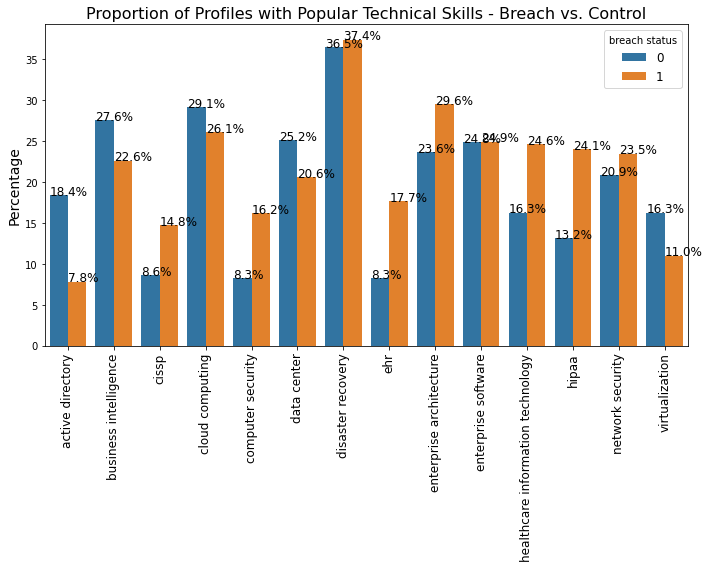

In [52]:
# plot barplot
fig_dims = (10, 8)
fig, ax = plt.subplots(figsize=fig_dims)
ax = sns.barplot(x="skill",
           y="prop",
           hue="breach",
           data=topskills2_melt_1)

for p in ax.patches:
    txt = str(p.get_height().round(1)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    ax.text(txt_x,txt_y,txt,fontsize=12)
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage', fontsize=14)
ax.set_xlabel('')
ax.set_title('Proportion of Profiles with Popular Technical Skills - Breach vs. Control', fontsize=16)
ax.legend(title = 'breach status',fontsize=12)

ax.set_xticklabels(topskills2_melt_1['skill'], rotation=90, fontsize=12)

fig.tight_layout()

plt.show()

# **Machine Learning Models**

In [53]:
# Create LabelEncoder object: le
le = LabelEncoder()

# Apply LabelEncoder to categorical columns
data[categorical_columns] = data[categorical_columns].apply(lambda x: le.fit_transform(x))

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
print(data[categorical_columns].head(2))

   breach  gender  highest_level  associates  bachelors  masters  doctorates  \
0       1       1              2           0          1        0           1   
1       1       1              3           0          1        1           0   

   mba  jd  md  ...  project portfolio management_skill  research_skill  \
0    0   0   1  ...                                   0               0   
1    1   0   0  ...                                   1               0   

   policy_skill  government_skill  technical support_skill  outsourcing_skill  \
0             0                 0                        0                  0   
1             0                 0                        0                  0   

   clinical research_skill  penetration testing_skill  \
0                        1                          0   
1                        0                          0   

   healthcare consulting_skill  pmp_skill  
0                            0          0  
1                            

#### **One-hot encode 'gender', 'highest_level'**

In [54]:
data = pd.get_dummies(data=data, columns=['gender','highest_level'])

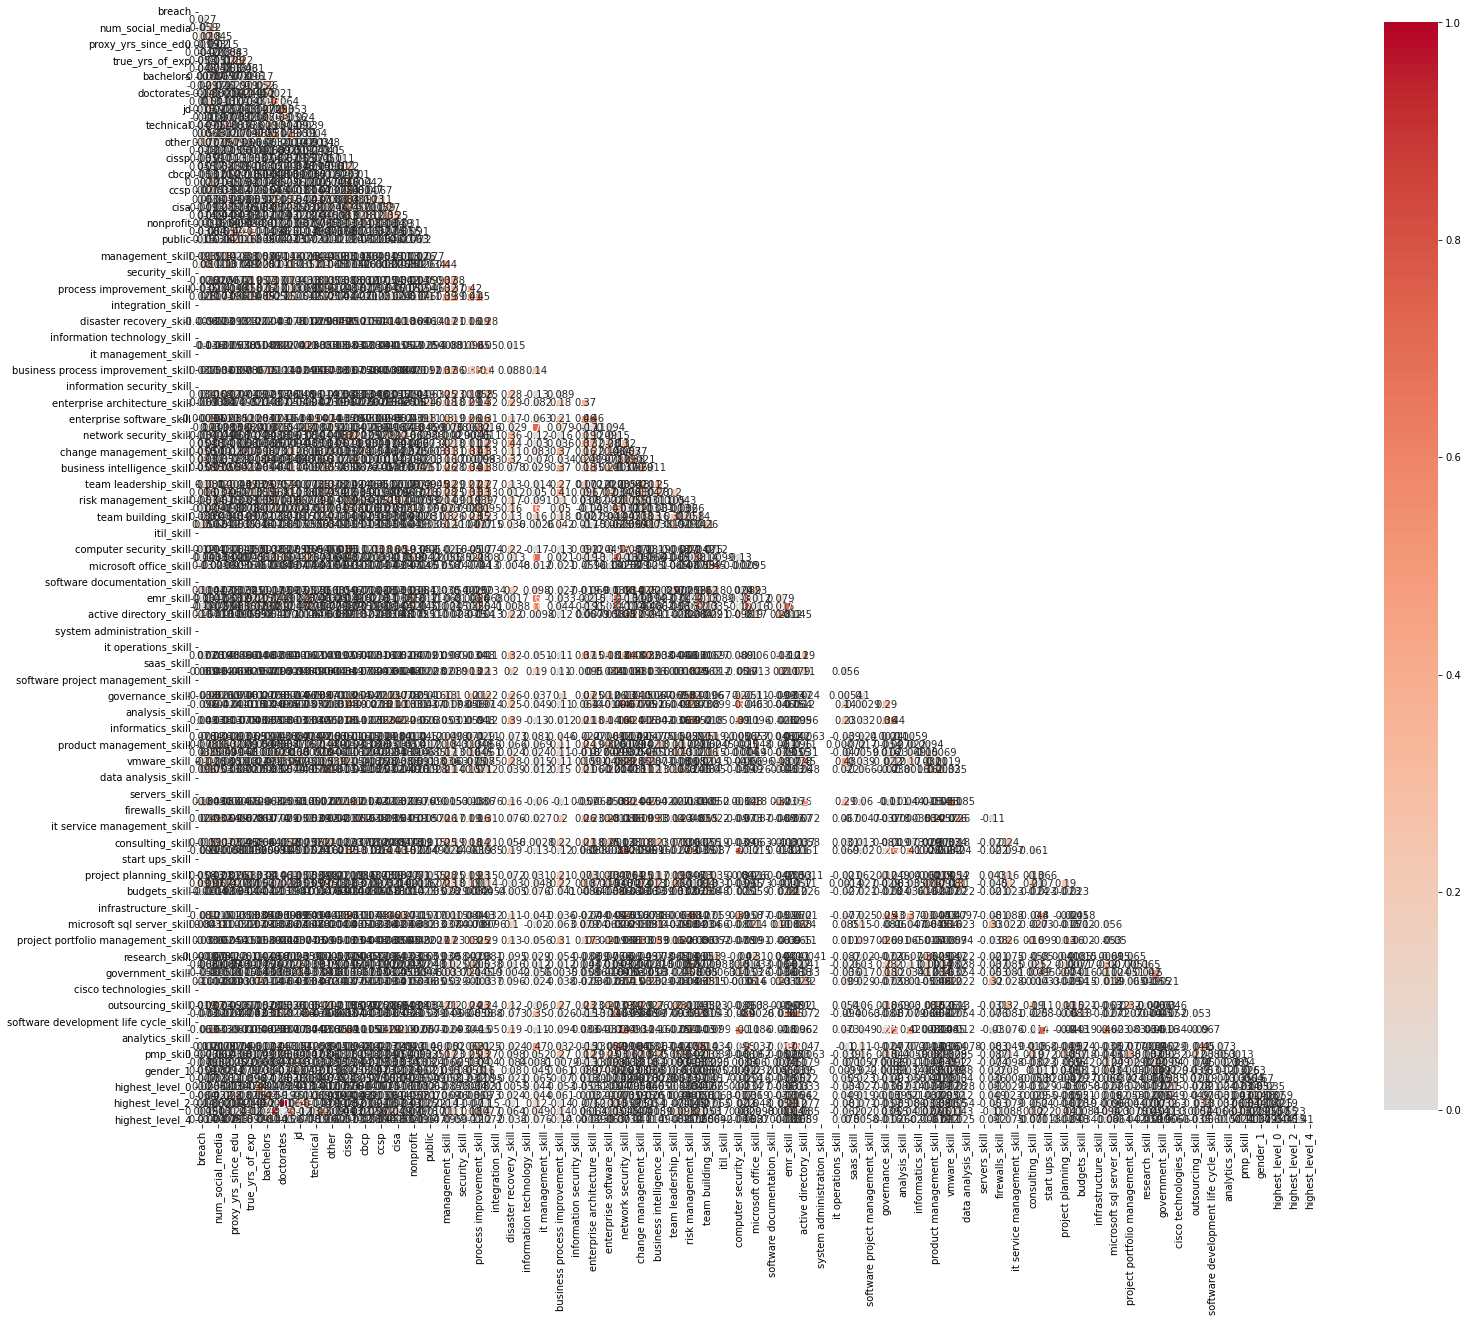

In [55]:
#Create the collinearity matrix

corr = data.corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True) #Color
mask = np.triu(np.ones_like(corr, dtype=bool)) #Masking the diagonoal and above
fig, ax = plt.subplots(figsize=(25,25))
sns.heatmap(corr, center=0, cmap="coolwarm", square=True,
linewidth=0.3, cbar_kws={"shrink": .8}, annot=True, mask=mask, vmin=0, vmax=1)

sns.set(font_scale=1.5) 

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler

In [57]:
X = data.drop('breach', axis=1)
y = data.breach

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671 entries, 0 to 670
Data columns (total 96 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   breach                                   671 non-null    int64  
 1   connections                              671 non-null    float64
 2   num_social_media                         671 non-null    int64  
 3   num languages                            671 non-null    int64  
 4   proxy_yrs_since_edu                      671 non-null    float64
 5   yrs_in_til_breach                        671 non-null    int64  
 6   true_yrs_of_exp                          671 non-null    int64  
 7   associates                               671 non-null    int64  
 8   bachelors                                671 non-null    int64  
 9   masters                                  671 non-null    int64  
 10  doctorates                               671 non-n

In [58]:
SEED = 1911
jobs = -1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=SEED)

In [59]:
# Transforming the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)  

X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)  

In [60]:
def plot_cf(y_true, y_pred, class_names=None, model_name=None):
    """Plots a confusion matrix"""
    cf = confusion_matrix(y_true, y_pred)
    plt.imshow(cf, cmap=plt.cm.Blues)
    plt.grid(b=None)
    if model_name:
        plt.title("Confusion Matrix: {}".format(model_name), color='w',fontweight='bold')
    else:
        plt.title("Confusion Matrix", color='w',fontweight='bold')
    plt.ylabel('True Label', color='w',fontweight='bold')
    plt.xlabel('Predicted Label', color='w',fontweight='bold')
    
    
    class_names = set(y_true)
    tick_marks = np.arange(len(class_names))
    if class_names:
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
    
    thresh = cf.max() / 2.
    
    for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
        plt.text(j, i, cf[i, j], horizontalalignment='center', color='white' if cf[i, j] > thresh else 'black')

    plt.colorbar()

# **Logistic Regression**

Logistic regression score for training set: 0.72761
Logistic regression score for test set: 0.57778

Classification report:
              precision    recall  f1-score   support

           0       0.58      0.64      0.61        69
           1       0.58      0.52      0.54        66

    accuracy                           0.58       135
   macro avg       0.58      0.58      0.58       135
weighted avg       0.58      0.58      0.58       135



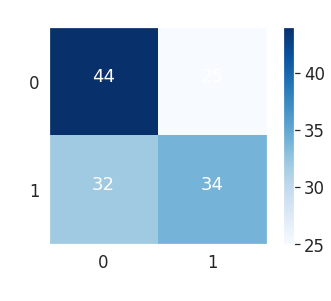

In [61]:
# Fitting a logistic regression model with default parameters
from sklearn.linear_model import LogisticRegression, SGDClassifier
lr = LogisticRegression(random_state=SEED, n_jobs=jobs)
lr.fit(X_train_scaled,y_train)
# Making predictions
y_pred = lr.predict(X_test_scaled)
# Logistic regression scores
print("Logistic regression score for training set:", round(lr.score(X_train_scaled, y_train),5))
print("Logistic regression score for test set:", round(lr.score(X_test_scaled, y_test),5))
print("\nClassification report:")
print(classification_report(y_test, y_pred))
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plot_cf(y_test, y_pred)

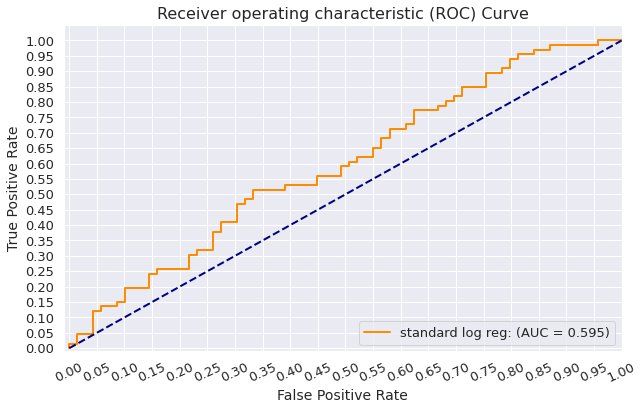

In [62]:
from sklearn import metrics
y_pred_proba = lr.predict_proba(X_test_scaled)[::,1]
lr_fpr, lr_tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
lr_auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
from matplotlib.ticker import FormatStrFormatter
plt.figure(figsize=(10,6))
lw = 2
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.plot(lr_fpr, lr_tpr, label='standard log reg: (AUC = %0.3f)' % lr_auc, color='darkorange',lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.ylabel('True Positive Rate',fontsize=14)
plt.xlabel('False Positive Rate',fontsize=14)
plt.yticks([i/20.0 for i in range(21)], fontsize=13)
plt.xticks([i/20.0 for i in range(21)], fontsize=13, rotation = 25)
plt.title('Receiver operating characteristic (ROC) Curve',fontsize=16)
plt.legend(loc=4, fontsize=13)
plt.show()

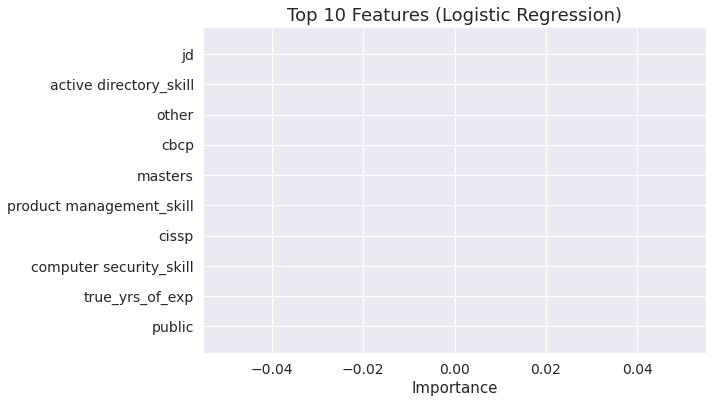

In [63]:
lr_feature_importance = abs(lr.coef_[0])
lr_feature_importance = 100.0 * (lr_feature_importance / lr_feature_importance.max())
sorted_idx = np.argsort(lr_feature_importance)
sorted_idx_10 = sorted_idx[:10]
#pos = np.arange(sorted_idx.shape[0]) + .5
pos_10 = np.arange(sorted_idx_10.shape[0]) + .05
lr_feature_importance_10=lr_feature_importance[sorted_idx][:10]


featfig = plt.figure(figsize=(9,6))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos_10, lr_feature_importance_10, align='center')
featax.set_yticks(pos_10)
featax.set_yticklabels(np.array(X.columns)[sorted_idx][-10:], fontsize=12)
featax.tick_params(axis='both', which='major', labelsize=14)
featax.set_xlabel('Relative Feature Importance',fontsize=15)
featax.set_xlabel('Importance',fontsize=15)
featax.set_title('Top 10 Features (Logistic Regression)',fontsize=18)


plt.rcParams['axes.grid'] = False
plt.rcParams['savefig.transparent'] = True
#fig.savefig('full_figure.png')
fig.savefig('myfile.png', bbox_inches = "tight")
fig.tight_layout()

plt.show()


# **Random Forest**

Random Forest score for training set: 1.0
Random Forest score for test set: 0.68148

Classification report:
              precision    recall  f1-score   support

           0       0.68      0.72      0.70        69
           1       0.69      0.64      0.66        66

    accuracy                           0.68       135
   macro avg       0.68      0.68      0.68       135
weighted avg       0.68      0.68      0.68       135



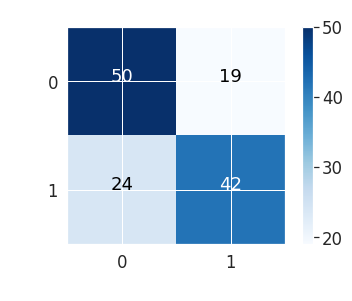

In [64]:
# Fitting a logistic regression model with default parameters
from sklearn.linear_model import LogisticRegression, SGDClassifier

rf = RandomForestClassifier(random_state=SEED)
rf.fit(X_train_scaled, y_train)
# Random Forest scores
y_pred = rf.predict(X_test_scaled)
print("Random Forest score for training set:", round(rf.score(X_train_scaled, y_train),5))
print("Random Forest score for test set:", round(rf.score(X_test_scaled, y_test),5))
print("\nClassification report:")
print(classification_report(y_test, y_pred))
plot_cf(y_test, y_pred, model_name='Random Forest')

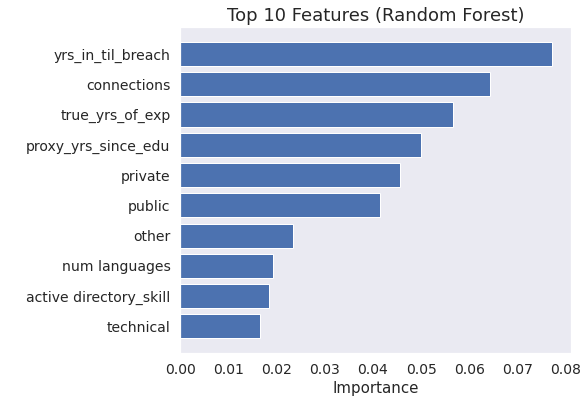

In [65]:
input_features = np.array(X_train_scaled.columns)
features_imp_rf = pd.DataFrame({'feature_name': input_features, 'feature_importance': rf.feature_importances_})
features_imp_rf = features_imp_rf.sort_values(by='feature_importance', ascending=False)
features_imp_rf_10 = features_imp_rf.head(10)
plt.figure(figsize=(7,6))
plt.barh(y=features_imp_rf_10['feature_name'], width=features_imp_rf_10['feature_importance'])
plt.xlabel("Importance",fontsize=15)
plt.ylabel(" ",fontsize=15)
plt.title("Top 10 Features (Random Forest)",fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.gca().invert_yaxis()

# **SVM**

Random Forest score for training set: 0.7444
Random Forest score for test set: 0.56296

Classification report:
              precision    recall  f1-score   support

           0       0.56      0.65      0.60        69
           1       0.56      0.47      0.51        66

    accuracy                           0.56       135
   macro avg       0.56      0.56      0.56       135
weighted avg       0.56      0.56      0.56       135



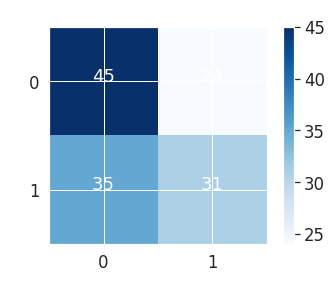

In [66]:
from sklearn import svm
# Initialize SVM classifier
svm_clf = svm.SVC(kernel='linear',random_state=SEED)

# Fit data
svm_clf = svm_clf.fit(X_train_scaled, y_train)
y_pred = svm_clf.predict(X_test_scaled)
print("Random Forest score for training set:", round(svm_clf.score(X_train_scaled, y_train),5))
print("Random Forest score for test set:", round(svm_clf.score(X_test_scaled, y_test),5))
print("\nClassification report:")
print(classification_report(y_test, y_pred))
plot_cf(y_test, y_pred)

# **KNN**

Random Forest score for training set: 0.78731
Random Forest score for test set: 0.56296

Classification report:
              precision    recall  f1-score   support

           0       0.57      0.62      0.59        69
           1       0.56      0.50      0.53        66

    accuracy                           0.56       135
   macro avg       0.56      0.56      0.56       135
weighted avg       0.56      0.56      0.56       135



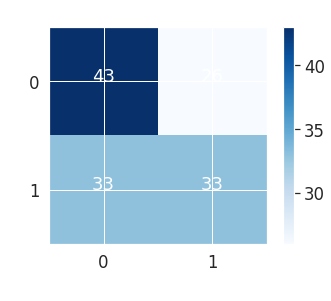

In [67]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
# Fit data
knn = knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)
print("Random Forest score for training set:", round(knn.score(X_train_scaled, y_train),5))
print("Random Forest score for test set:", round(knn.score(X_test_scaled, y_test),5))
print("\nClassification report:")
print(classification_report(y_test, y_pred))
plot_cf(y_test, y_pred)

# **AdaBoost**

Accuracy: 0.5555555555555556
AdaBoostClassifier score for training set: 0.77799
AdaBoostClassifier score for test set: 0.55556

Classification report:
              precision    recall  f1-score   support

           0       0.56      0.61      0.58        69
           1       0.55      0.50      0.52        66

    accuracy                           0.56       135
   macro avg       0.56      0.55      0.55       135
weighted avg       0.56      0.56      0.55       135



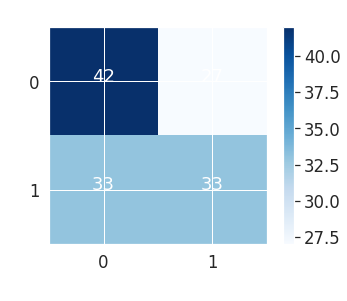

In [68]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

#rf = RandomForestClassifier(random_state=SEED)
#lr= LogisticRegression(random_state=SEED, n_jobs=jobs)
dt = DecisionTreeClassifier(max_depth=1)
abc = AdaBoostClassifier(n_estimators=50,base_estimator=dt,
                         learning_rate=1)
# Train Adaboost Classifer
model = abc.fit(X_train_scaled, y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test_scaled)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

print("AdaBoostClassifier score for training set:", round(model.score(X_train_scaled, y_train),5))
print("AdaBoostClassifier score for test set:", round(model.score(X_test_scaled, y_test),5))
print("\nClassification report:")
print(classification_report(y_test, y_pred))
plot_cf(y_test, y_pred, model_name='AdaBoost')



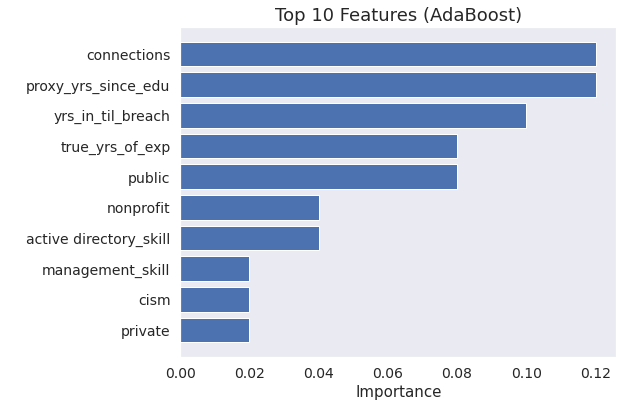

In [69]:
input_features = np.array(X_train_scaled.columns)
features_imp_ada = pd.DataFrame({'feature_name': input_features, 'feature_importance': abc.feature_importances_})
features_imp_ada = features_imp_ada.sort_values(by='feature_importance', ascending=False)
features_imp_ada_10 = features_imp_ada.head(10)
plt.figure(figsize=(9,6))
plt.barh(y=features_imp_ada_10['feature_name'], width=features_imp_ada_10['feature_importance'])
plt.xlabel("Importance",fontsize=15)
plt.ylabel(" ",fontsize=15)
plt.title("Top 10 Features (AdaBoost)",fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()


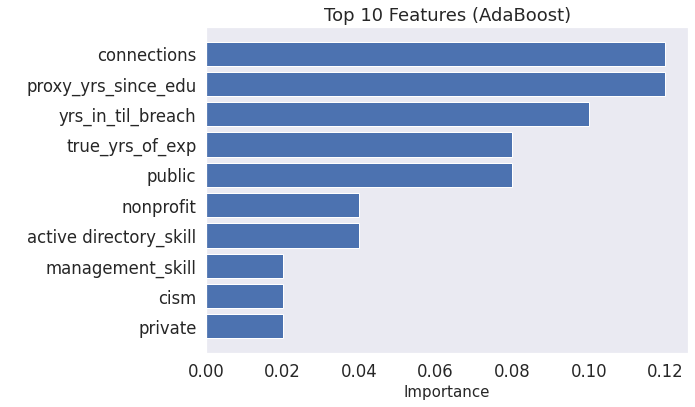

In [70]:
fig_dims = (10, 6)
fig, ax = plt.subplots(figsize=fig_dims)
ax.barh(y=features_imp_ada_10['feature_name'], width=features_imp_ada_10['feature_importance'])
ax.set_xlabel("Importance",fontsize=15)
ax.set_ylabel(" ",fontsize=15)
ax.set_title("Top 10 Features (AdaBoost)",fontsize=18)
#plt.tick_params(axis='both', which='major', labelsize=14, color='w')
plt.gca().invert_yaxis()

plt.rcParams['axes.grid'] = False
plt.rcParams['savefig.transparent'] = True
#fig.savefig('full_figure.png')
fig.savefig('file.png', bbox_inches = "tight")
fig.tight_layout()

plt.show()



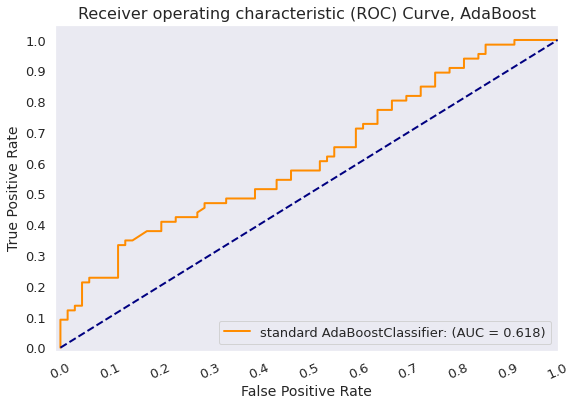

In [71]:
from sklearn import metrics
y_pred_proba = model.predict_proba(X_test_scaled)[::,1]
lr_fpr, lr_tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
lr_auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
from matplotlib.ticker import FormatStrFormatter
plt.figure(figsize=(9,6))
lw = 2
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.plot(lr_fpr, lr_tpr, label='standard AdaBoostClassifier: (AUC = %0.3f)' % lr_auc, color='darkorange',lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.ylabel('True Positive Rate',fontsize=14)
plt.xlabel('False Positive Rate',fontsize=14)
plt.yticks([i/10.0 for i in range(11)], fontsize=13)
plt.xticks([i/10.0 for i in range(11)], fontsize=13, rotation = 25)
plt.title('Receiver operating characteristic (ROC) Curve, AdaBoost',fontsize=16)
plt.legend(loc=4, fontsize=13)
plt.show()

In [ ]:
## PCA
from sklearn.decomposition import PCA #import 
pca=PCA(n_components=3)                #initialize 
pca.fit(X_train_scaled)               #fit 
X_train_scaled_pca = pca.transform(X_train_scaled) #transform
X_test_scaled_pca = pca.transform(X_test_scaled)

#how much variance is captured
pca.explained_variance_ratio_ #0.075+0.072 = about 15% of the variance in the data --> PCA not good?

array([0.0757761 , 0.07254489, 0.05538772])

# **Cross Validation**

In [ ]:

import warnings
from sklearn.model_selection import cross_validate
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline

models = [RandomForestClassifier(random_state=SEED),
          LinearSVC(),
          LogisticRegression(random_state=SEED),
          #AdaBoostClassifier(n_estimators=50,base_estimator=RandomForestClassifier(random_state=SEED),learning_rate=1),
          #AdaBoostClassifier(n_estimators=50,base_estimator=LogisticRegression(penalty='none'),learning_rate=1),
          AdaBoostClassifier(n_estimators=50,base_estimator= DecisionTreeClassifier(max_depth=1)),
          KNeighborsClassifier(n_neighbors=3),
         GaussianNB()
          ]

scoring = {'acc': 'accuracy',
           'prec_macro': 'precision_macro',
           'rec_macro': 'recall_macro',
           'f1_macro': 'f1_macro'}

CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)


class StScaler(StandardScaler):
    def fit_transform(self,X,y=None):
        #print('Length of Data on which scaler is fit on =', len(X))
        output = super().fit(X,y)
        #print('mean of scalar =',output.mean_)
        output = super().transform(X)
        return output

entries = []
for model in models:
  model_name = model.__class__.__name__
  warnings.filterwarnings("ignore")
  clf = model
  pipeline = Pipeline([('sc', StScaler()), ('estimator', clf)])
  scores = cross_validate(pipeline, X, y, scoring = scoring, cv=CV, return_train_score=True) #dictionary of (metric: score for each fold))
  for metric, score in scores.items():
    entries.append((model_name, metric, score))
  print(model_name) 
  print("Mean Test Accuracy: ", scores['test_acc'].mean(),"; STD Test Accuracy: ", scores['test_acc'].std())
  print("Mean Test Precision(macro): ", scores['test_prec_macro'].mean(),"; STD Test Precision(macro): ", scores['test_prec_macro'].std())
  print("Mean Test Recall(macro): ", scores['test_rec_macro'].mean(),"; STD Test Recall(macro): ", scores['test_rec_macro'].std()) 
  print("Mean Test F1(macro): ", scores['test_f1_macro'].mean(),"; STD Test F1(macro): ", scores['test_f1_macro'].std()) 
  print('\n')

cv_df = pd.DataFrame(entries, columns=['model_name', 'metric', 'score'])


RandomForestClassifier
Mean Test Accuracy:  0.6572581536760641 ; STD Test Accuracy:  0.03199876360529983
Mean Test Precision(macro):  0.6588891518261988 ; STD Test Precision(macro):  0.032101716005942554
Mean Test Recall(macro):  0.6566869362521537 ; STD Test Recall(macro):  0.0327909256934649
Mean Test F1(macro):  0.6554953569130044 ; STD Test F1(macro):  0.03300076270561964


LinearSVC
Mean Test Accuracy:  0.5961525704809286 ; STD Test Accuracy:  0.03900325466360529
Mean Test Precision(macro):  0.5969670817352846 ; STD Test Precision(macro):  0.038302502055985635
Mean Test Recall(macro):  0.5957737914259653 ; STD Test Recall(macro):  0.03815068289829339
Mean Test F1(macro):  0.5945022277870986 ; STD Test F1(macro):  0.03896154852237112


LogisticRegression
Mean Test Accuracy:  0.5931785516860144 ; STD Test Accuracy:  0.04724843501558259
Mean Test Precision(macro):  0.5938493232102873 ; STD Test Precision(macro):  0.04668088154545382
Mean Test Recall(macro):  0.5928985507246377 ; STD 

In [ ]:
cv_df['mean_score']= cv_df['score'].apply(np.mean)
cv_df

,model_name,metric,score,mean_score
0,RandomForestClassifier,fit_time,"[0.2273845672607422, 0.2167673110961914, 0.205...",0.216453
1,RandomForestClassifier,score_time,"[0.020343780517578125, 0.018836498260498047, 0...",0.020426
2,RandomForestClassifier,test_acc,"[0.6370370370370371, 0.6865671641791045, 0.671...",0.657258
3,RandomForestClassifier,train_acc,"[1.0, 1.0, 1.0, 1.0, 1.0]",1.000000
4,RandomForestClassifier,test_prec_macro,"[0.6411642890013806, 0.6867280485066247, 0.675...",0.658889
5,RandomForestClassifier,train_prec_macro,"[1.0, 1.0, 1.0, 1.0, 1.0]",1.000000
6,RandomForestClassifier,test_rec_macro,"[0.6347167325428195, 0.6853957636566332, 0.673...",0.656687
7,RandomForestClassifier,train_rec_macro,"[1.0, 1.0, 1.0, 1.0, 1.0]",1.000000
8,RandomForestClassifier,test_f1_macro,"[0.6318659914296845, 0.6854460093896713, 0.670...",0.655495
9,RandomForestClassifier,train_f1_macro,"[1.0, 1.0, 1.0, 1.0, 1.0]",1.000000


In [ ]:
scores.items()

dict_items([('fit_time', array([0.05076981, 0.01379514, 0.01371098, 0.01390123, 0.01478982])), ('score_time', array([0.01347136, 0.01011705, 0.00942135, 0.01024652, 0.00997806])), ('estimator', [Pipeline(steps=[('sc', StScaler()), ('estimator', GaussianNB())]), Pipeline(steps=[('sc', StScaler()), ('estimator', GaussianNB())]), Pipeline(steps=[('sc', StScaler()), ('estimator', GaussianNB())]), Pipeline(steps=[('sc', StScaler()), ('estimator', GaussianNB())]), Pipeline(steps=[('sc', StScaler()), ('estimator', GaussianNB())])]), ('test_acc', array([0.56296296, 0.54477612, 0.5       , 0.55970149, 0.5       ])), ('train_acc', array([0.57835821, 0.53258845, 0.55679702, 0.55307263, 0.5735568 ])), ('test_prec_macro', array([0.62912309, 0.65119048, 0.62115385, 0.66896186, 0.52701271])), ('train_prec_macro', array([0.68731719, 0.69435426, 0.68159712, 0.67162905, 0.68266034])), ('test_rec_macro', array([0.57048748, 0.55663322, 0.51404682, 0.57112598, 0.51137124])), ('train_rec_macro', array([0.58

In [ ]:
cv_df.info()

cv_df_test = cv_df[cv_df['metric'].isin(['test_acc','test_prec_macro','test_rec_macro','test_f1_macro'])]
cv_df_train = cv_df[cv_df['metric'].isin(['train_acc','train_prec_macro','train_rec_macro','train_f1_macro'])]
cv_df_time = cv_df[cv_df['metric'].isin(['fit_time','score_time'])]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   model_name  60 non-null     object 
 1   metric      60 non-null     object 
 2   score       60 non-null     object 
 3   mean_score  60 non-null     float64
dtypes: float64(1), object(3)
memory usage: 2.0+ KB


# **Model Performance Comparison**

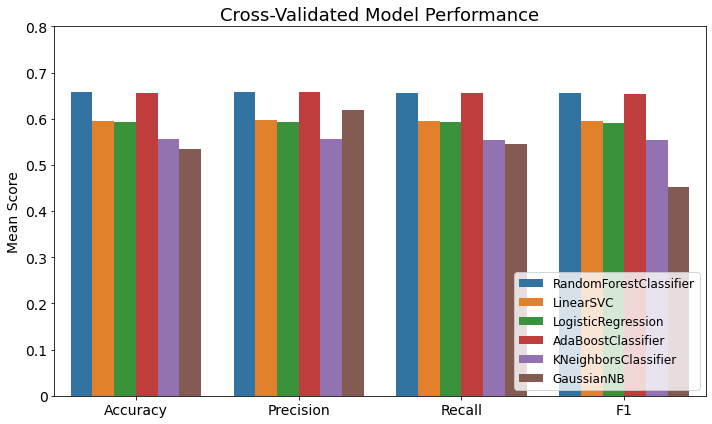

In [ ]:
# plot barplot
fig_dims = (10, 6)
fig, ax = plt.subplots(figsize=fig_dims)
ax = sns.barplot(x="metric",
           y="mean_score",
           hue="model_name",
           data=cv_df_test)

ax.set_ylabel('Mean Score', fontsize=14)
ax.set_xlabel('', fontsize=14)
ax.set_ylim([0, 0.8])
ax.set_title('Cross-Validated Model Performance', fontsize=18)
ax.legend(title = '',fontsize=12, loc= 'lower right' )
ax.set_xticklabels(['Accuracy','Precision','Recall','F1'], rotation=0, fontsize=14)
ax.set_yticklabels([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8], rotation=0, fontsize=14)
plt.rcParams['axes.grid'] = False
plt.rcParams['savefig.transparent'] = True
#fig.savefig('full_figure.png')
fig.savefig('myfile.png', bbox_inches = "tight")
fig.tight_layout()

plt.show()

fig.tight_layout()

plt.show()

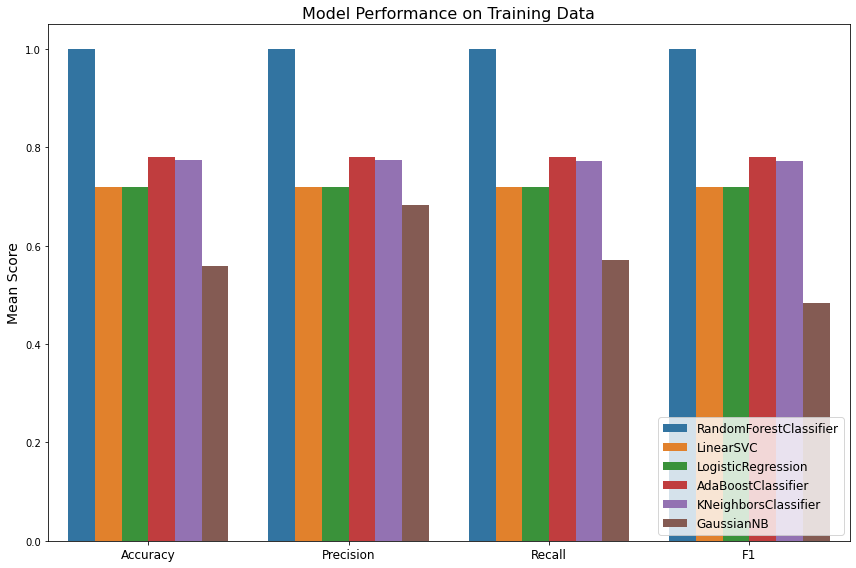

In [ ]:
# plot barplot
fig_dims = (12, 8)
fig, ax = plt.subplots(figsize=fig_dims)
ax = sns.barplot(x="metric",
           y="mean_score",
           hue="model_name",
           data=cv_df_train)

ax.set_ylabel('Mean Score', fontsize=14)
ax.set_xlabel('', fontsize=14)
ax.set_title('Model Performance on Training Data', fontsize=16)
ax.legend(title = '',fontsize=12, loc= 'lower right' )
ax.set_xticklabels(['Accuracy','Precision','Recall','F1'], rotation=0, fontsize=12)


fig.tight_layout()

plt.show()

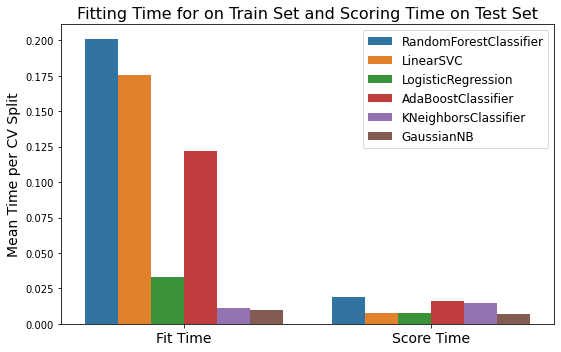

In [ ]:
# plot barplot
fig_dims = (8, 5)
fig, ax = plt.subplots(figsize=fig_dims)
ax = sns.barplot(x="metric",
           y="mean_score",
           hue="model_name",
           data=cv_df_time)

ax.set_ylabel('Mean Time per CV Split', fontsize=14)
ax.set_xlabel('', fontsize=14)
ax.set_title('Fitting Time for on Train Set and Scoring Time on Test Set', fontsize=16)
ax.legend(title = '',fontsize=12, loc= 'upper right' )
ax.set_xticklabels(['Fit Time','Score Time'], rotation=0, fontsize=14)


fig.tight_layout()

plt.show()